sources: 

- https://www.kaggle.com/hone5com/fraud-detection-with-variational-autoencoder
- https://www.tensorflow.org/probability/api_docs/python/tfp/layers/KLDivergenceRegularizer

In [118]:
_DEBUG_          = False # general flag for debug mode
_D_ZERO_DATA_    = True  # basically a debug mode in order to overfit the model on the most simple data
_USING_2D_DATA_  = True

assert _USING_2D_DATA_, '3d currently not implemented'

In [2]:
from datetime import date
from datetime import timedelta

_NIGHTLY_VERSION_ = 20190312 # 20190430 # 20190502 # 20190312
#_NIGHTLY_VERSION_ = str((date(2019, 3, 19) - timedelta(days=diff))).replace('-', '')
#_NIGHTLY_VERSION_ = str((date.today() - timedelta(days=diff))).replace('-', '')
#!pip -q install --upgrade tf-nightly==1.14.1-dev{_NIGHTLY_VERSION_} \
#                          tf-nightly-gpu==1.14.1-dev{_NIGHTLY_VERSION_} \
#                          tfp-nightly==0.7.0.dev20190312
#!pip -q install --upgrade tf-nightly tf-nightly-gpu tfp-nightly

In [119]:
# Import TensorFlow >= 1.9 and enable eager execution
import tensorflow as tf
tfe = tf.contrib.eager
tf.enable_eager_execution()


from tensorflow.python import tf2
if not tf2.enabled():
    import tensorflow.compat.v2 as tf
    #import tensorflow.compat.v1 as tf
    tf.enable_v2_behavior()
    assert tf2.enabled()

import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
#import imageio
from IPython import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import inspect

# Doesn't work with TF2
#from keras.backend.tensorflow_backend import set_session
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
#sess = tf.Session(config=config)
#set_session(sess) # set this TensorFlow session as the default session for Keras

from tensorflow.keras.utils import plot_model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.manifold import TSNE
import os

%matplotlib inline
from som_vae.helpers.misc import extract_args, chunks, foldl
from som_vae.helpers.jupyter import fix_layout, display_video
from som_vae.settings import config, skeleton
from som_vae.helpers import video, plots, misc, jupyter
from som_vae import preprocessing
from som_vae.helpers.logging import enable_logging

In [120]:
jupyter.fix_layout()

In [121]:
### Utility Functions
## Plots
# Plot Feature Projection [credit: https://www.kaggle.com/shivamb/semi-supervised-classification-using-autoencoders]
def tsne_plot(x1, y1, name=None):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)
#     plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud', s=2)

    plt.legend(loc='best');
    #plt.savefig(name);
    plt.title('tsne')
    plt.show();
    
    
# Plot Keras training history
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [122]:
from som_vae import settings
from som_vae import preprocessing

joint_positions, normalisation_factors = preprocessing.get_data_and_normalization(settings.data.EXPERIMENTS)

frames_idx_with_labels = preprocessing.get_frames_with_idx_and_labels(settings.data.LABELLED_DATA)[:len(joint_positions)]

#frames_of_interest = frames_idx_with_labels.label.isin([settings.data._BehaviorLabel_.GROOM_ANT, settings.data._BehaviorLabel_.WALK_FORW, settings.data._BehaviorLabel_.REST])
frames_of_interest = ~frames_idx_with_labels.label.isin([settings.data._BehaviorLabel_.REST])

joint_positions = joint_positions[frames_of_interest]
frames_idx_with_labels = frames_idx_with_labels[frames_of_interest]

W0505 14:59:28.266968 139873666684736 preprocessing.py:67] this works only for the first legs!
W0505 14:59:28.687849 139873666684736 preprocessing.py:67] this works only for the first legs!
W0505 14:59:29.816679 139873666684736 preprocessing.py:67] this works only for the first legs!
W0505 14:59:30.192376 139873666684736 preprocessing.py:67] this works only for the first legs!
W0505 14:59:30.548393 139873666684736 preprocessing.py:67] this works only for the first legs!


In [123]:
# flatten the data
if _USING_2D_DATA_:
    reshaped_joint_position = joint_positions[:,:,:2].reshape(joint_positions.shape[0], -1).astype(np.float32)
else:
    raise NotImplementedError()

if _DEBUG_ and _D_ZERO_DATA_:
    reshaped_joint_position = np.zeros_like(reshaped_joint_position)

# scaling the data to be in [0, 1]
# this is due to the sigmoid activation function in the reconstruction
#scaler = MinMaxScaler()
scaler = StandardScaler()
#resh = scaler.fit_transform(resh)

print(f"total number of input data:{reshaped_joint_position.shape}")


#if som_vae_config['time_series']:
#    _time_series_idx_ = list(to_time_series(range(len(joint_positions))))
#    _jp = np.concatenate([joint_positions[idx].reshape(1, -1, 30) for idx in _time_series_idx_], axis=0)
#else:
#    _jp = joint_positions
#    
#nb_of_data_points = (reshaped_joint_position.shape[0] // config['batch_size']) * config['batch_size']
# train - test split
n_of_data_points = int(reshaped_joint_position.shape[0] * 0.7)
#
data_train = scaler.fit_transform(reshaped_joint_position[:n_of_data_points])
data_test = scaler.transform(reshaped_joint_position[n_of_data_points:])
# just generating some labels, no clue what they are for except validation?
#labels = frames_idx_with_labels['label'].apply(lambda x: x.value).values

#if som_vae_config['time_series']:
#    labels = np.concatenate([labels[idx].reshape(1, -1, 1) for idx in _time_series_idx_], axis=0)

#data = {
#  "X_train": data_train,
#  "X_val": data_test,
#  "y_train": labels[:nb_of_data_points],
#  "y_val": labels[nb_of_data_points:]
#}


total number of input data:(1538, 30)


In [124]:
pd.DataFrame(data_train).describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,1.076000e+03,1.076000e+03,1.076000e+03,1.076000e+03,1.076000e+03,1.076000e+03,1.076000e+03,1.076000e+03,1.076000e+03,1.076000e+03,...,1.076000e+03,1.076000e+03,1.076000e+03,1076.000000,1.076000e+03,1.076000e+03,1.076000e+03,1.076000e+03,1076.000000,1.076000e+03
mean,6.381464e-08,-6.062390e-07,-9.217670e-08,-2.836206e-08,7.090515e-08,4.963361e-08,-2.836206e-08,-2.836206e-08,-1.506735e-07,-2.836206e-08,...,-3.899783e-07,1.985344e-07,2.694396e-07,0.000000,-4.254309e-08,1.134482e-07,2.836206e-08,2.836206e-08,0.000000,-7.799567e-08
std,1.000461e+00,1.000467e+00,1.000465e+00,1.000468e+00,1.000464e+00,1.000464e+00,1.000464e+00,1.000465e+00,1.000466e+00,1.000466e+00,...,1.000465e+00,1.000469e+00,1.000460e+00,1.000465,1.000467e+00,1.000464e+00,1.000465e+00,1.000465e+00,1.000465,1.000467e+00
min,-3.268696e+00,-3.902151e+00,-2.217446e+00,-2.243847e+00,-2.563538e+00,-1.879824e+00,-2.954363e+00,-2.654323e+00,-3.503287e+00,-2.116326e+00,...,-1.197483e+00,-2.485652e+00,-2.618914e+00,-1.460636,-2.236300e+00,-1.349191e+00,-2.465984e+00,-1.825940e+00,-2.550841,-5.871113e+00
25%,-3.788874e-01,3.211311e-01,-8.119871e-01,-3.104360e-01,-6.699849e-01,-8.503415e-01,-5.668350e-01,-6.281112e-01,-4.883301e-01,-7.550508e-01,...,-1.197483e+00,-1.179551e+00,-6.248813e-01,-0.011440,-7.325723e-01,-7.526713e-01,-8.894245e-01,-6.939594e-01,-0.821354,-9.748621e-01
50%,5.843822e-01,3.211311e-01,-3.435008e-01,-3.104360e-01,3.230715e-01,-2.675533e-02,-1.779541e-01,3.849946e-01,5.005497e-02,5.381609e-01,...,6.451992e-01,1.265500e-01,-6.248813e-01,-0.011440,-2.552518e-02,-1.561516e-01,5.657123e-02,-1.210227e-01,0.043390,4.387994e-03
75%,5.843822e-01,3.211311e-01,5.934716e-01,6.562696e-01,6.438058e-01,7.968309e-01,5.473445e-01,7.226966e-01,4.807630e-01,7.423522e-01,...,6.451992e-01,1.291824e-01,1.369151e+00,-0.011440,6.815219e-01,6.392080e-01,1.002567e+00,7.314360e-01,1.004217,6.572214e-01
max,1.547652e+00,3.019928e+00,3.872875e+00,2.589681e+00,2.407845e+00,2.855796e+00,3.571546e+00,1.735802e+00,3.065011e+00,1.286862e+00,...,4.125884e+00,2.738752e+00,3.363184e+00,1.681672,1.742092e+00,3.678865e+00,1.495347e+00,3.572965e+00,2.061126,2.942138e+00


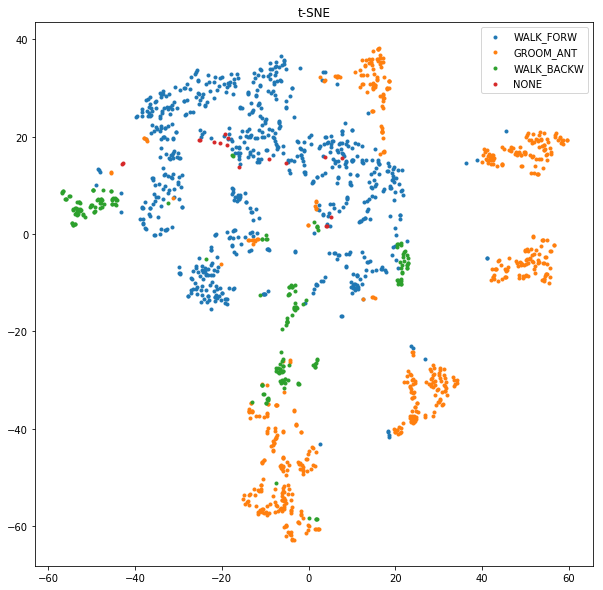

In [125]:
plots.plot_tnse(np.concatenate((data_train, data_test)), frames_idx_with_labels);

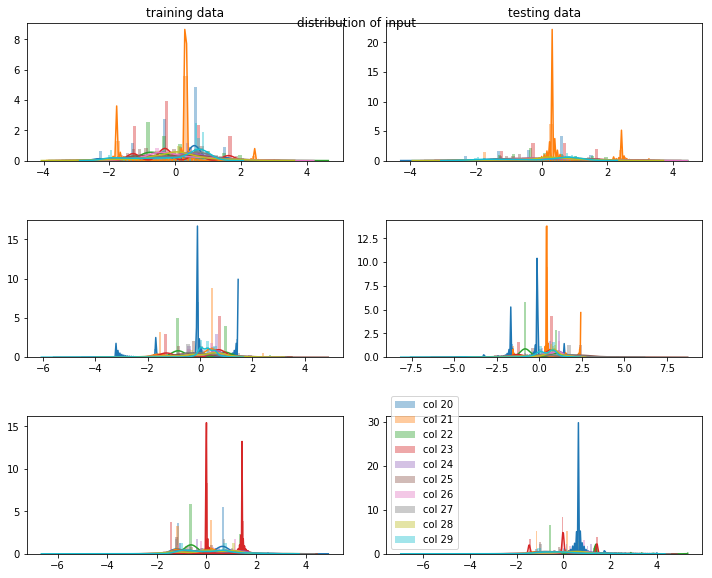

In [126]:
if _USING_2D_DATA_:
    plots.plot_2d_distribution(data_train, data_test);
else:
    raise ValueError('not yet implemented for 3d data')

In [157]:
def dense_layers(sizes):
    return tfk.Sequential([tfkl.Dense(size, activation=tf.nn.leaky_relu) for size in sizes])

tf.reset_default_graph()

original_dim = data_train.shape[1]
input_shape = data_train[0].shape
latent_dim = 10
dense_layer_dims = np.linspace(input_shape, latent_dim, 4).astype(np.int)
batch_size = 128
max_epochs = 1000


prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_dim))
#prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_dim), scale=1), reinterpreted_batch_ndims=1)

encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape, name='encoder_input'),
    dense_layers(dense_layer_dims),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim), activation=None),
    tfpl.MultivariateNormalTriL(latent_dim, activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=0.5)),
], name='encoder')

print(encoder.summary())
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[latent_dim]),
    dense_layers(reversed(dense_layer_dims)),
    tfkl.Dense(tfpl.IndependentNormal.params_size(original_dim), activation=None),
    tfpl.IndependentNormal(original_dim),
], name='decoder')

print(decoder.summary())
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# Taking only the mean of the VAE `outputs[0]`
vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]),
                name='vae_mlp')

negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.keras.optimizers.Adam(), loss=negative_log_likelihood)

vae.summary()
#plot_model(vae,
#           to_file='vae_mlp.png',
#           show_shapes=True)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 10)                2197      
_________________________________________________________________
dense_4 (Dense)              (None, 65)                715       
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 10), (None, 10))  0         
Total params: 2,912
Trainable params: 2,912
Non-trainable params: 0
_________________________________________________________________
None
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 30)                1397      
_________________________________________________________________
dense_9 (Dense)              (None, 60)                1860      
___________________________________

In [158]:
tf_train = tf.data.Dataset.from_tensor_slices((data_train, data_train))\
             .batch(batch_size)\
             .prefetch(tf.data.experimental.AUTOTUNE)\
             .shuffle(int(10e4))
tf_val = tf.data.Dataset.from_tensor_slices((data_test, data_test))\
           .batch(batch_size)\
           .prefetch(tf.data.experimental.AUTOTUNE)\
           .shuffle(int(10e4))

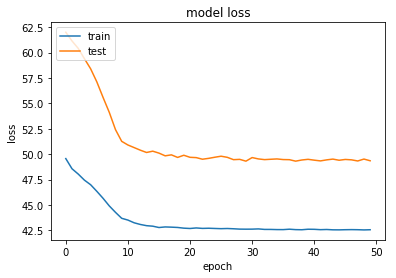

In [159]:
from pathlib import Path
from datetime import datetime
file_path_model_checkpoint = f"{config.__DATA_ROOT__}/neural_clustering_data/experimental/model_checkpoints/vae_v2-0.1.0_{datetime.now():%Y-%m-%d_%H-%M-%S%z}.h5"
#Path(file_path_model_checkpoint).parent.mkdir(parents=True, exist_ok=True)

checkpointer = ModelCheckpoint(filepath=file_path_model_checkpoint, 
                               verbose=0,
                               save_best_only=True)

earlystopper = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.005, patience=20, verbose=0, restore_best_weights=True)

hist = vae.fit(tf_train,
               epochs=max_epochs,
               shuffle=True,
               verbose=0,
               validation_data=tf_val,
               callbacks=[checkpointer, earlystopper])


plot_loss(hist)

# reconstruction

In [160]:
reconstruct_samples_n = 100

def reconstruction_log_prob(eval_samples, reconstruct_samples_n):
    encoder_out = encoder(eval_samples)
    encoder_samples = encoder_out.sample(reconstruct_samples_n)
    return np.mean(decoder(encoder_samples).log_prob(eval_samples), axis=0)

In [161]:
def _reverse_to_original_shape_(pos_data, input_shape=None):
    if input_shape is None:
        if config.NB_DIMS == 2:
            input_shape = (-1, config.NB_DIMS)
        else:
            input_shape = (-1,)
        
    return scaler.inverse_transform(pos_data).reshape(pos_data.shape[0], *(input_shape))

reconstructed_train =  _reverse_to_original_shape_(vae(data_train).sample())
reconstructed_test  =  _reverse_to_original_shape_(vae(data_test).sample())

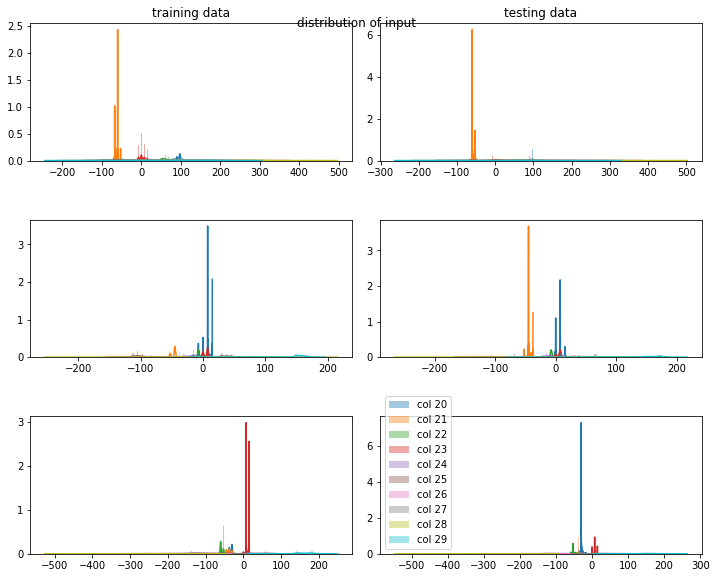

In [162]:
plots.plot_2d_distribution(reshaped_joint_position[:n_of_data_points], reshaped_joint_position[n_of_data_points:]);

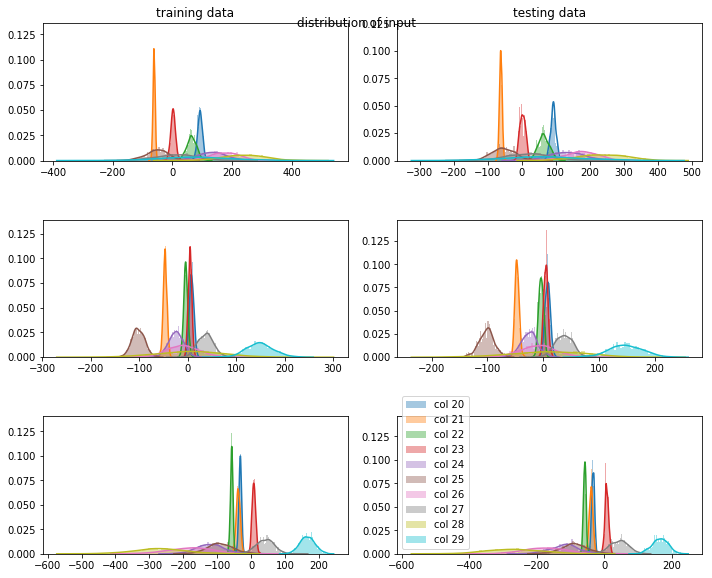

In [163]:
plots.plot_2d_distribution(reconstructed_train, reconstructed_test);

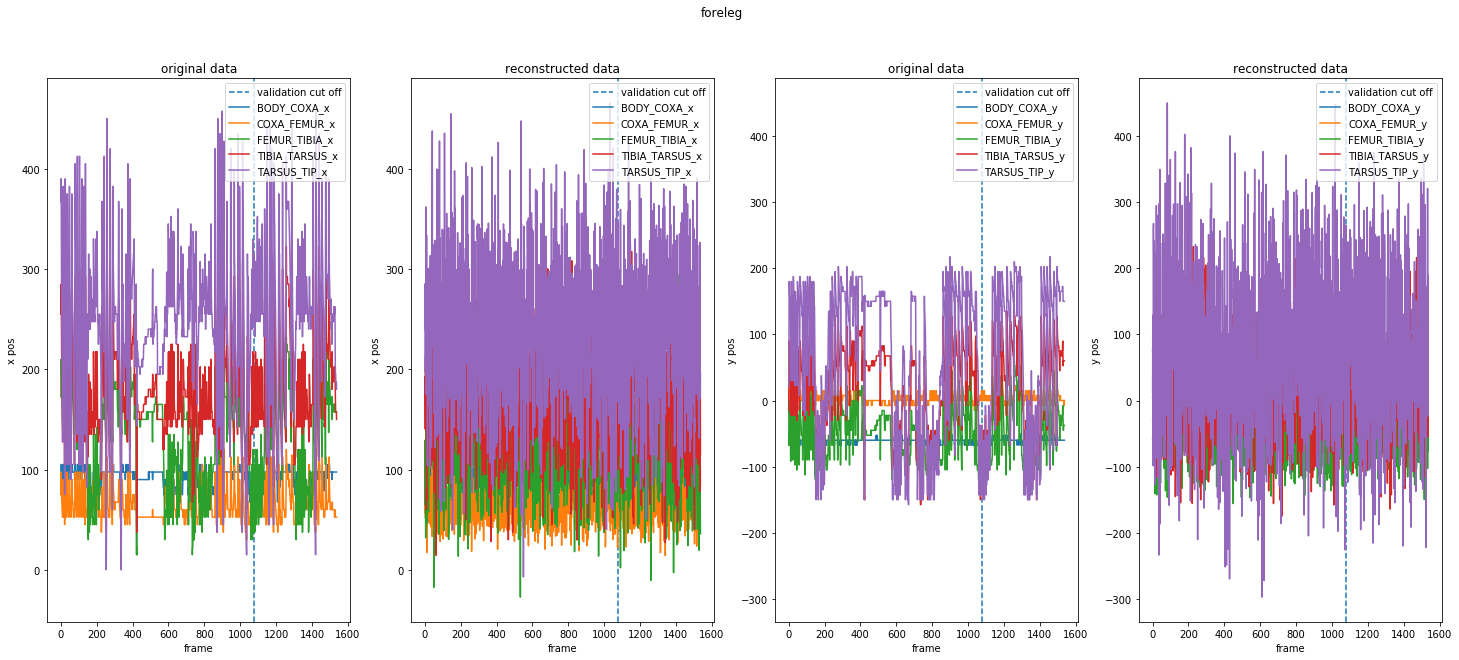

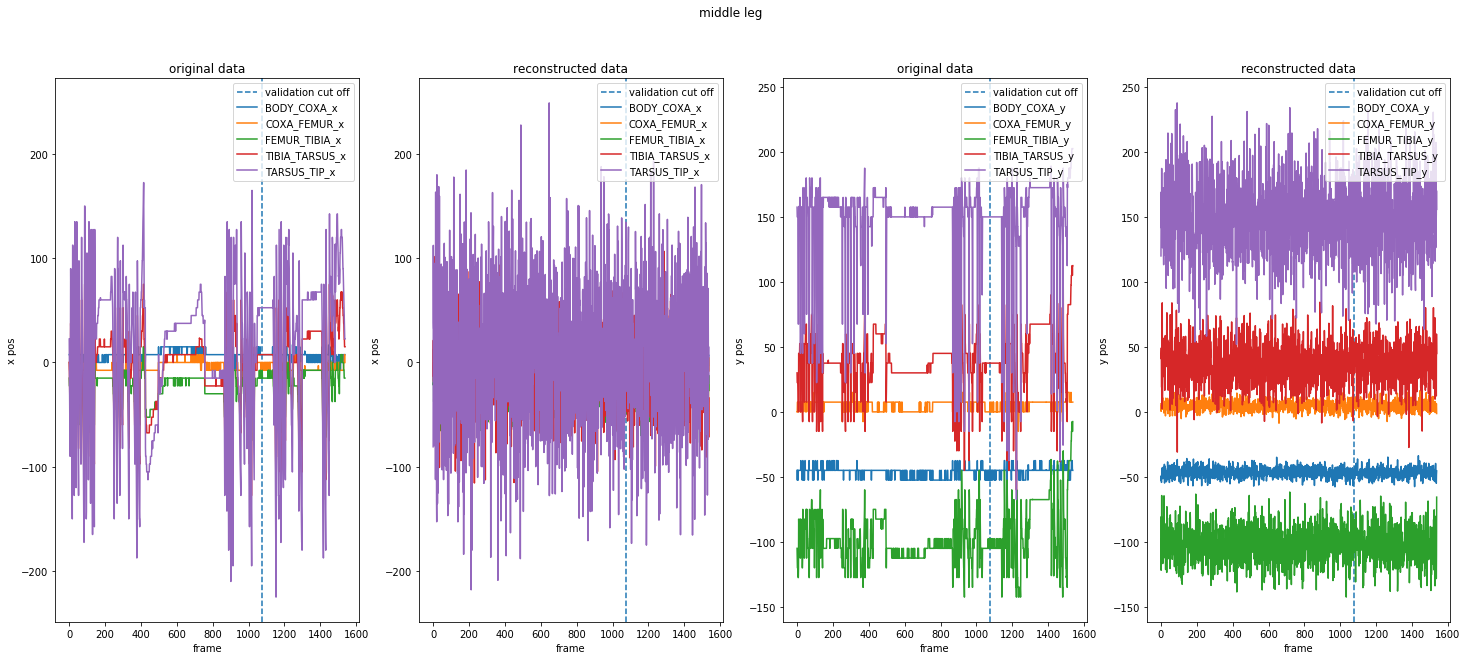

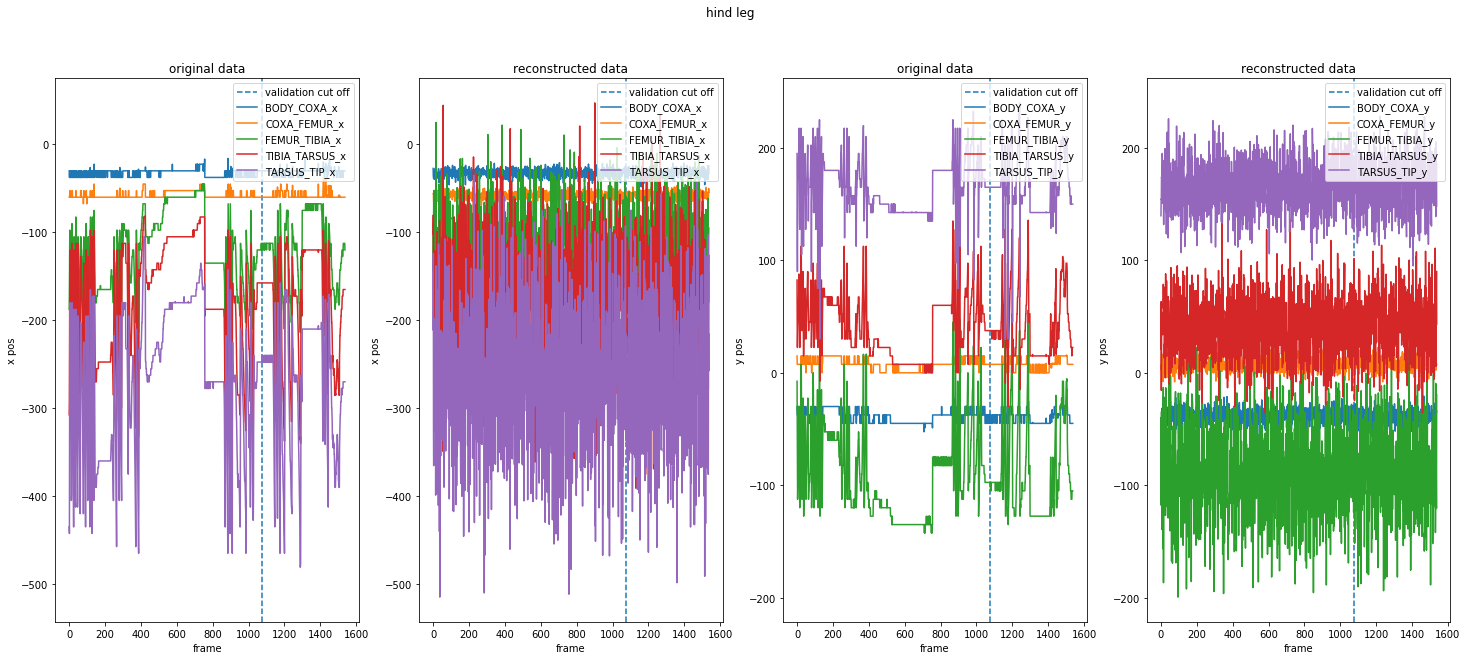

In [164]:
plots.plot_comparing_joint_position_with_reconstructed(joint_positions, 
                                                       np.vstack((reconstructed_train, reconstructed_test)).reshape(-1, 15, 2), 
                                                       validation_cut_off=n_of_data_points)

# latent space plot

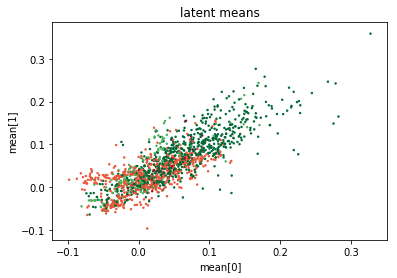

In [165]:
Y = frames_idx_with_labels.label.apply(lambda x: x.value)
X = np.vstack((data_train, data_test))
latent_x_mean = encoder(X).mean()
latent_x_stddev  = encoder(X).stddev()

plt.scatter(latent_x_mean[:, 0], latent_x_mean[:, 1], c=Y, cmap='RdYlGn_r', s=2)
plt.title('latent means')
plt.ylabel('mean[1]')
plt.xlabel('mean[0]')
plt.show()

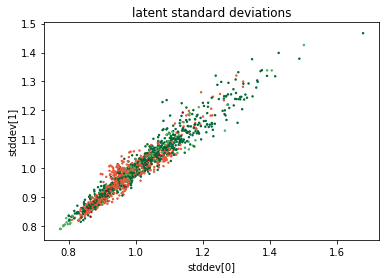

In [166]:
plt.scatter(latent_x_stddev[:, 0], latent_x_stddev[:, 1], c=Y, cmap='RdYlGn_r', s=2)
plt.title('latent standard deviations')
plt.ylabel('stddev[1]')
plt.xlabel('stddev[0]')
plt.show()

## sampling

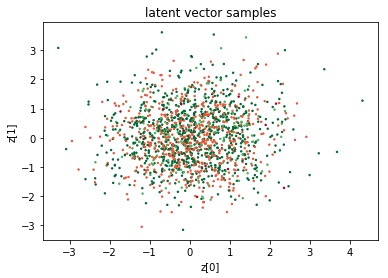

In [167]:
latent_x = encoder(X).sample()
plt.scatter(latent_x[:, 0], latent_x[:, 1], c=Y, cmap='RdYlGn_r', s=2)
plt.title('latent vector samples')
plt.ylabel('z[1]')
plt.xlabel('z[0]')
plt.show()

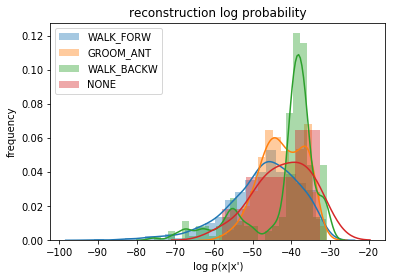

In [173]:
seen_labels =  frames_idx_with_labels.label.unique()

x_log_prob = reconstruction_log_prob(X, reconstruct_samples_n)
#ax = plt.hist(x_log_prob, 60)
for l in seen_labels:
    sns.distplot(x_log_prob[frames_idx_with_labels['label'] == l], label=l.name)
    
plt.legend()
plt.title('reconstruction log probability')
plt.ylabel('frequency')
plt.xlabel("log p(x|x')")
plt.show()